# APLICACIONES EN CIENCIAS DE COMPUTACION

## Laboratorio 3: Operadores de Algoritmos Geneticos para resolver el problema de las n-reinas

Abajo puede encontrar la implementacion de un algoritmo genético para resolver el problema de las n-reinas. El algoritmo ya esta implementado y funcionando con algunos operadores basicos. La clase Individual_nqueens implementa el individuo para este problema. Tiene 2 atributos: chromosome y fitness. Cromosome es una lista, donde el elemento i indica la posicion de la reina en la columna i. El fitness es el nro de pares de reinas que no se atacan y se puede obtener llamando a la funcion fitness_nqueens(). La clase individuo también implementa el operador de cruzamiento de un punto (crossover_onepoint) y el operador de mutacion swap (mutate_swap). 

La tarea de este laboratorio consiste en implementar en la clase Individual_nqueensen dos nuevos operadores (marcados con #TODO): el operador de cruzamiento uniforme (crossover_uniform) y el operador de mutación que cambia aleatoriamente la posicion de una reina (mutate_position).

Al final de este notebook puede encontrar las tareas y cuestiones que seran evaluadas en este laboratorio.

<b>Clase abstracta de un individuo de algoritmo genético (no modificar)</b>

In [46]:
class Individual:
    "Clase abstracta para individuos de un algoritmo evolutivo."

    def __init__(self, chromosome):
        self.chromosome = chromosome

    def crossover(self, other):
        "Retorna un nuevo individuo cruzando self y other."
        raise NotImplementedError
        
    def mutate(self):
        "Cambia los valores de algunos genes."
        raise NotImplementedError        

<b>Clase concreta de un individuo del problema de las n-reinas</b> (Falta implementar crossover_uniform y mutate_position)

In [47]:
import random

class Individual_nqueens(Individual):
    "Clase que implementa el individuo en el problema de las n-reinas."

    def __init__(self, chromosome):
        self.chromosome = chromosome[:]
        self.fitness = -1

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre self y other "
        c = random.randrange(len(self.chromosome))
        ind1 = Individual_nqueens(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual_nqueens(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   
    
    def crossover_uniform(self, other):
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        ind1=[]
        ind2=[]
        for i in range(len(self.chromosome)-1):
            c=random.randrange(0,2)
            if(c==0):
                ind1.append(self.chromosome[i])
                ind2.append(other.chromosome[i])
            else:
                ind1.append(other.chromosome[i])
                ind2.append(self.chromosome[i])
        return[Individual_nqueens(ind1), Individual_nqueens(ind2)]
          

    def mutate_position(self):
        "Cambia aleatoriamente la posicion de una reina."
        c=random.randrange(0,len(self.chromosome)-1)
        f=random.randrange(0,len(self.chromosome)-1)
        mutated_ind = Individual_nqueens(self.chromosome[:])
        mutated_ind[c]=f
        return mutated_ind
        
    def mutate_swap(self):
        "Intercambia la posicion de dos genes."
        mutated_ind = Individual_nqueens(self.chromosome[:])
        indexOne = random.randint(0,len(mutated_ind.chromosome)-1)
        indexTwo = random.randint(0,len(mutated_ind.chromosome)-1)
        temp = mutated_ind.chromosome[indexOne]
        mutated_ind.chromosome[indexOne] = mutated_ind.chromosome[indexTwo]
        mutated_ind.chromosome[indexTwo] = temp
        return mutated_ind

<b>Funcion de fitness para evaluar un individuo del problema de las n-reinas</b>

In [48]:
def fitness_nqueens(chromosome):
    """Retorna el fitness de un cromosoma en el problema de las n-reinas (nro de pares de reinas no atacadas) """
    n = len(chromosome)  # nro de reinas
    fitness = 0
    for i in range(n-1):
        for j in range(i+1, n):
            # si el par de reinas i, j  no etan en la misma fila o diagonales => par no atacado
            if chromosome[j] not in [chromosome[i], chromosome[i] - (j-i),  chromosome[i] + (j-i)]:
                fitness = fitness + 1
    return fitness

<b>Funcion para evaluar toda una población de individuos con la funcion de fitnes especificada</b>

In [49]:
def evaluate_population(population, fitness_fn):
    """ Evalua una poblacion de individuos con la funcion de fitness pasada """
    popsize = len(population)
    for i in range(popsize):
        if population[i].fitness == -1:    # si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].chromosome)

<b>Funcion que selecciona con el metodo de la ruleta un par de individuos de population para cruzamiento </b>

In [50]:
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
     
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

<b>Funcion que selecciona sobrevivientes para la sgte generacion, dada la poblacion actual y poblacion de hijos </b>

In [51]:
def select_survivors(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors): next_population.append(population[isurvivors[i]])
    return next_population

<b>Algoritmo Genetico</b>   
Recibe una poblacion inicial, funcion de fitness, numero de generaciones (ngen) y taza de mutación (pmut)

In [77]:
def genetic_algorithm(population, fitness_fn, ngen=100, pmut=0.1):
    "Algoritmo Genetico "
    
    popsize = len(population)
    evaluate_population(population, fitness_fn)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
    bestfitness = [population[ibest[0]].fitness]
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion
        
        ## Selecciona las parejas de padres para cruzamiento 
        mating_pool = []
        for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population)) 
        
        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            #offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                #offspring_population[i] = offspring_population[i].mutate_swap()        # mutacion swap
                offspring_population[i] = offspring_population[i].mutate_position()   # mutacion de una posicion
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, fitness_fn)  # evalua la poblacion inicial
        
        ## Selecciona popsize individuos para la sgte. generación de la union de la pob. actual y  pob. descendencia
        population = select_survivors(population, offspring_population, popsize)

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        print("generacion {}, best_fitness = {}".format(g, population[ibest[0]].fitness))
    
    return population[ibest[0]], bestfitness  

 <b>Algoritmo de Busqueda Genetica para el problema de las n-reinas</b>   

In [53]:
def genetic_search_nqueens(fitness_fn, num_queens=10, popsize=10, ngen=100, pmut=0.1):
    import random
    population = []

    ## Crea la poblacion inicial con cromosomas aleatorios
    #for i in range(popsize):
    #    chromosome = [j for j in range(1,num_queens+1)]
    #    random.shuffle(chromosome)
    #    population.append( Individual_nqueens(chromosome) )
        
    ## Crea la poblacion inicial con los siguientes cromosomas    
    chromosomes = [[1,3,1,3,1,3,1,3,1,3],
                   [2,4,2,4,2,4,2,4,2,4],
                   [3,5,3,5,3,5,3,5,3,5],
                   [4,6,4,6,4,6,4,6,4,6],
                   [5,7,5,7,5,7,5,7,5,7],
                   [6,8,6,8,6,8,6,8,6,8],
                   [7,9,7,9,7,9,7,9,7,9],
                   [8,10,8,10,8,10,8,10,8,10],
                   [9,1,9,1,9,1,9,1,9,1],
                   [10,2,10,2,10,2,10,2,10,2] ]   
    for i in range(popsize):
        population.append( Individual_nqueens(chromosomes[i]) )   
        
    ## llama al algoritmo genetico para encontrar una solucion al problema de las n reinas
    return genetic_algorithm(population, fitness_fn, ngen, pmut)        

# Tareas y cuestiones:

<b>1) Comparar el desempeño de los operadores de cruzamiento (8 puntos)</b> 

Aqui vamos a comparar el desempeño de los 2 operadores de cruzamiento implementados. Para ello probaremos en el problema de 10 reinas, 10 individuos y taza de mutación = 0 (a fin de centrarnos solo en el efecto de cruzamiento). Ejecute 10 veces el codigo abajo con crossover_onepoint (registrando el best_fitness de la generacion 99 en cada ejecución) y luego calcule la media de los valores registrados. Repita el experimento con crossover_uniform (comente la linea de crossover_onepoint y descomente la linea de crossover_uniform  en genetic_algorithm() ). Note que la funcion genetic_search_nqueens tiene una población inicial predefinida. Esto se ha hecho para descontar también la variabilidad de la poblacion inicial, asi solo la calidad de los operadores estaria influyendo en los resultados. 

Poblacion inicial, best_fitness = 25
generacion 0, best_fitness = 33
generacion 1, best_fitness = 35
generacion 2, best_fitness = 35
generacion 3, best_fitness = 37
generacion 4, best_fitness = 37
generacion 5, best_fitness = 38
generacion 6, best_fitness = 39
generacion 7, best_fitness = 40
generacion 8, best_fitness = 40
generacion 9, best_fitness = 40
generacion 10, best_fitness = 40
generacion 11, best_fitness = 40
generacion 12, best_fitness = 40
generacion 13, best_fitness = 40
generacion 14, best_fitness = 40
generacion 15, best_fitness = 40
generacion 16, best_fitness = 40
generacion 17, best_fitness = 40
generacion 18, best_fitness = 40
generacion 19, best_fitness = 40
generacion 20, best_fitness = 40
generacion 21, best_fitness = 40
generacion 22, best_fitness = 40
generacion 23, best_fitness = 40
generacion 24, best_fitness = 40
generacion 25, best_fitness = 40
generacion 26, best_fitness = 40
generacion 27, best_fitness = 40
generacion 28, best_fitness = 40
generacion 29, b

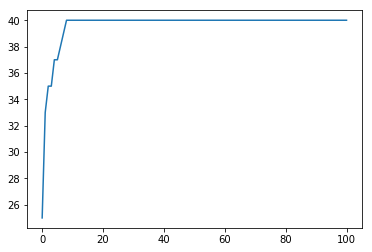

In [84]:
import matplotlib.pyplot as plt
best_ind, bestfitness = genetic_search_nqueens(fitness_nqueens, 10, 10, 100, 0.0)
plt.plot(bestfitness)
plt.show()

<b> - ¿Cual de los dos operadores de cruzamiento consigue en media mejores resultados? </b> Intente dar una justificativa al respecto.       

El primer operador, crossover_onepoint, tiene una media de 40.7 pares de reinas que no se atacan mientras que el segundo operador,crossover_uniform tiene una media de 29.6 pares de reinas que no se atacan. Dado que el onepoint solo divide una parte del chromosoma del padre y lo copia en el hijo, este guarda (una cadena de estados) la información de los padres combinados y si en esta se encuentra un estado óptimo, este pasa al hijo. Sin embargo, en el uniform, cada parte del chromosoma de los padres hacia el hijo pasan individualmente a los hijos, no como conjunto, lo que ocasiona que si el padre ya tenia estados óptimos estos se pierdan al realizar el crossover_uniform.

Tambien, se puede deber a que como la población es fija, el rol explotativo de la recombinación hace que evoluya a individuos con la mejor combinacion de alelos observados en el proceso evolutivo. Dado que si la poblacion inicial tiene unos alelos optimos, el one point los conservará y dara mejores resultados que un uniform.

<b>2) Buscar la mejor combinación de operadores (12 puntos)</b> 

Ahora deberá identificar el mejor operador de mutación para trabajar junto con el operador de cruzamiento indentificado en la tarea anterior. Para ello deberá realizar 2 experimentos similares a la tarea 1: deje fijo el operador de cruzamiento identificado en la tarea 1 y experimente cada operador de mutacion por separado (ejecutando 10 veces el codigo abajo). La taza de mutación a probar es pmut=0.25 (mutacion sucede en aprox. un 25 % de los hijos). 

Poblacion inicial, best_fitness = 25
generacion 0, best_fitness = 32
generacion 1, best_fitness = 38
generacion 2, best_fitness = 38
generacion 3, best_fitness = 39
generacion 4, best_fitness = 39
generacion 5, best_fitness = 39
generacion 6, best_fitness = 39
generacion 7, best_fitness = 39
generacion 8, best_fitness = 39
generacion 9, best_fitness = 39
generacion 10, best_fitness = 39
generacion 11, best_fitness = 41
generacion 12, best_fitness = 42
generacion 13, best_fitness = 42
generacion 14, best_fitness = 43
generacion 15, best_fitness = 43
generacion 16, best_fitness = 43
generacion 17, best_fitness = 43
generacion 18, best_fitness = 43
generacion 19, best_fitness = 43
generacion 20, best_fitness = 43
generacion 21, best_fitness = 43
generacion 22, best_fitness = 43
generacion 23, best_fitness = 43
generacion 24, best_fitness = 43
generacion 25, best_fitness = 43
generacion 26, best_fitness = 43
generacion 27, best_fitness = 43
generacion 28, best_fitness = 43
generacion 29, b

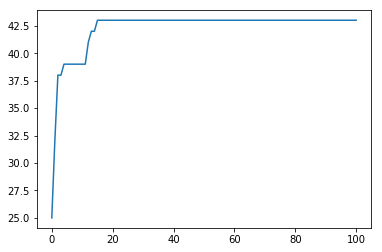

In [122]:
best_ind, bestfitness = genetic_search_nqueens(fitness_nqueens, 10, 10, 100, 0.25)
plt.plot(bestfitness)
plt.show()

<b> - ¿Los resultados con los operadores de mutación son mejores que con solo cruzamiento? porque? </b>

Si, porque al haber mutación, la probabilidad de no estancarse y encontrar una solución existe. En cambio, de no haberla y tener todos los padres sin ningun estado objetivo nunca se llegaría a la solución deseada. 

Ya que la mutación tiene rol explorativo, ayuda a ampliar la fuente de generación de nuevos alelos en la población con la esperanza de escapar de la convergencia actual.

<b> - ¿Con cuál de los dos operadores de mutación se consigue en media mejores resultados? </b> Intente dar una justificativa al respecto.      

Con el operador swap. En este caso, uno desea que las reinas no se encuentren en una misma fila y eso se asegura con el operador de mutación swap ya que intercambia los valores (0 al 8) de posicion. En cambio, la mutacion por posicion lo que hace es escoger aleatoriamente una posición del chromosoma y cambiar su estado a cualquier estado posible, es decir, si tengo una reina ubicada en el (3,3) y la ubicacion al azar escogida es la cuadro, tendria un (4,_) donde el _ será el valor aleatorio que se asignará, el cual puede llegar a ser un 3 y entraría en conflicto con la reina anterior (3,3) cosa que no pasa en el operador de mutacion swap.